In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings, os, random, string

warnings.filterwarnings("ignore")
random.seed(0)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/gloveglobalvectors/glove.6B.100d.txt


In [2]:
import nltk, re
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam


Using TensorFlow backend.


In [3]:
pre = '/kaggle/input/nlp-getting-started/'
train_df = pd.read_csv(pre + 'train.csv')
test_df = pd.read_csv(pre + 'test.csv')

***1) Exploratary Data Analysis***

In [4]:
print(train_df.shape)
print(len(train_df.location.unique()))
print(len(train_df.keyword.unique()), '\n')
print(train_df.isnull().sum()/len(train_df)) #location not a reliable variable
train_df.head()

(7613, 5)
3342
222 

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print(test_df.shape)
print(len(test_df.location.unique()))
print(len(test_df.keyword.unique()), '\n')
print(test_df.isnull().sum()/len(test_df))
test_df.head()

(3263, 4)
1603
222 

id          0.000000
keyword     0.007968
location    0.338645
text        0.000000
dtype: float64


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Count of 0s: 4342
Count of 1s: 3271


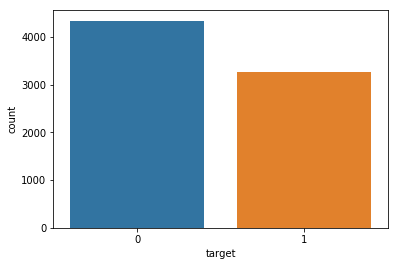

In [6]:
sns.countplot(train_df.target, data=train_df);
print('Count of 0s: {}'.format(len(train_df[train_df.target==0])))
print('Count of 1s: {}'.format(len(train_df[train_df.target==1])))
#count of response variable is balanced

In [7]:
keywordtbl = train_df.groupby('keyword')['target'].aggregate({'Cnt': 'count', 'Total': 'sum', 'Prob': 'mean'}).reset_index()
print(keywordtbl.Cnt.min())
print(keywordtbl.Cnt.max())
keywords_high_p = list(keywordtbl[(keywordtbl['Cnt'] > 4) & (keywordtbl['Prob'] > 0.98)]['keyword'])
print(keywords_high_p)
keywordtbl.sort_values('Prob', ascending=False).head(10)

9
45
['debris', 'derailment', 'wreckage']


,keyword,Cnt,Total,Prob
62,debris,37,37,1.000000
219,wreckage,39,39,1.000000
70,derailment,39,39,1.000000
153,outbreak,40,39,0.975000
152,oil%20spill,38,37,0.973684
205,typhoon,38,37,0.973684
187,suicide%20bombing,33,32,0.969697
186,suicide%20bomber,31,30,0.967742
32,bombing,29,27,0.931034
166,rescuers,35,32,0.914286


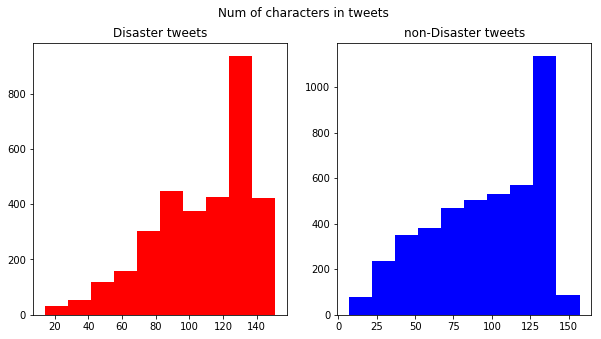

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
tweetlen = train_df[train_df['target']==1]['text'].str.len()
ax1.hist(tweetlen, color='red')
ax1.set_title('Disaster tweets')
tweetlen = train_df[train_df['target']==0]['text'].str.len()
ax2.hist(tweetlen, color='blue')
ax2.set_title('non-Disaster tweets')
fig.suptitle('Num of characters in tweets')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

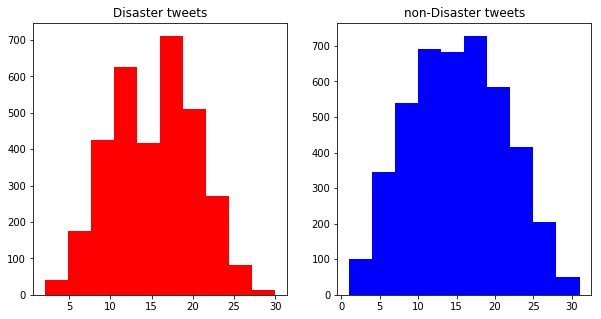

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
tweetlen = train_df[train_df['target']==1]['text'].str.split().apply(lambda x: len(x))
ax1.hist(tweetlen, color = 'red')
ax1.set_title('Disaster tweets')
tweetlen = train_df[train_df['target']==0]['text'].str.split().apply(lambda x: len(x))
ax2.hist(tweetlen, color = 'blue')
ax2.set_title('non-Disaster tweets')
plt.show

In [10]:
#keywords & target
print('Percentage of non-null keywords in non-disaster tweets: {}'.format(len(train_df[(pd.notnull(train_df.keyword)) & (train_df.target == 0)])/len(train_df.target == 0)))
print('Percentage of non-null keywords in disaster tweets: {}'.format(len(train_df[(pd.notnull(train_df.keyword)) & (train_df.target == 1)])/len(train_df.target == 1)))

Percentage of non-null keywords in non-disaster tweets: 0.5678444765532642
Percentage of non-null keywords in disaster tweets: 0.42414291343754107


In [11]:
#Frequent stop words
from collections import defaultdict
def create_corpus(target):
    corpus=[]
    
    for x in train_df[train_df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus=create_corpus(0)
stop=set(stopwords.words('english'))

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x, y = zip(*top)

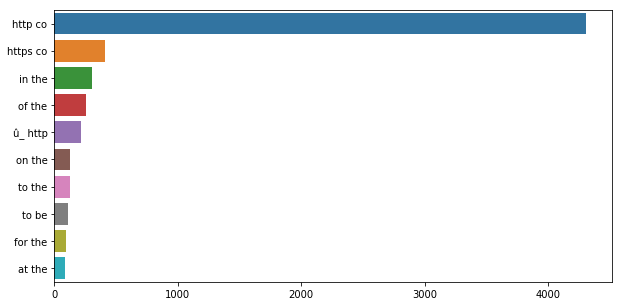

In [12]:
def get_top_bigrams(corpus, n=None):
    corpus = train_df['text']
    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

plt.figure(figsize=(10,5))
top_bigrams = get_top_bigrams(train_df['text'])[:10]
top_bigrams
x, y = map(list, zip(*top_bigrams))
sns.barplot(y=x,x=y)


% of disaster tweets with @: 20.67%
% of non-disaster tweets with @: 31.39%


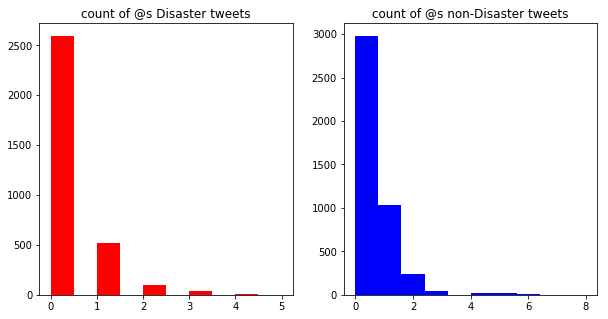

In [13]:
#distribution of @s in tweets
ref0 = train_df[train_df['target']==0]['text'].str.findall(r'[@]').apply(lambda x: len(x)>0)
ref1 = train_df[train_df['target']==1]['text'].str.findall(r'[@]').apply(lambda x: len(x)>0)

countref0 = train_df[train_df['target']==0]['text'].str.findall(r'[@]').apply(lambda x: len(x))
countref1 = train_df[train_df['target']==1]['text'].str.findall(r'[@]').apply(lambda x: len(x))

print('% of disaster tweets with @: {:.2%}'.format(ref1.mean()))
print('% of non-disaster tweets with @: {:.2%}'.format(ref0.mean()))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
_ = ax1.hist(countref1, color = 'red')
_ = ax1.set_title('count of @s Disaster tweets')
_ = ax2.hist(countref0, color = 'blue')
_ = ax2.set_title('count of @s non-Disaster tweets')

***2) Feature Extraction***

In [17]:
def ext_features(df):
    #Create features on original text
    textvect = df['text']
    stextvect = df['text'].apply(lambda x: x.replace(' ', ''))
    df['digit_count'] = textvect.str.count(r'\d')
    df['nonword_char_count'] = stextvect.str.count(r'[\W]')
    df['length_space'] = textvect.str.len()
    df['length_no_space'] = stextvect.str.len()

    #'d?d:dd' [inaccurate]
    df['4d_element'] = df['text'].str.findall(r'(\d?\d):(\d\d)')
    df['4d_element'] = df['4d_element'].apply(lambda x: len(x)!=0)
    return df

train_df = ext_features(train_df)
text_df = ext_features(test_df)

#encoding of categorical variables (keyword)
from category_encoders import WOEEncoder
woedf = WOEEncoder(cols='keyword').fit_transform(train_df['keyword'], train_df['target'])
train_df['keyword_woe'] = woedf
keyworddict = pd.Series(train_df.keyword_woe.values,index=train_df.keyword).to_dict()
test_df['keyword_woe'] = [keyworddict[v] for v in test_df.keyword]

#0 vs 1: digit_count, nonword_char_count, length_space
train_df.groupby(['target'])[['digit_count', 'nonword_char_count', 'length_space', 'keyword_woe', '4d_element']].mean()

,digit_count,nonword_char_count,length_space,keyword_woe,4d_element
target,,,,,
0,1.590511,6.423768,95.706817,-0.674231,0.006218
1,2.637420,7.701620,108.113421,0.816410,0.025986


***Text Normalization***

In [18]:
X_train = train_df['text']
X_test = test_df['text']

def norm_features(df):
    #remove char sequence in brackets
    df = df.apply(lambda x: re.sub('\[.*?\]', '', x))
    
    #remove links
    df = df.apply(lambda x: re.sub('https?://\S+|www\.\S+', '', x))
    
    #remove newlines
    df = df.apply(lambda x: re.sub('\n', '', x))
    
    #remove numbers
    df = df.apply(lambda x: re.sub('\w*\d\w*', '', x))

    #remove punctuations
    df = df.apply(lambda x: re.sub('[^\w\s]', '', x))
    
    #remove html
    df = df.apply(lambda x: re.sub('<.*?>', '', x))
    
    #convert to lower case
    df = df.apply(lambda x: x.lower())
    
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    df = df.apply(lambda x: ' '.join([i for i in nltk.word_tokenize(x) if i not in stop_words]))
    
    #stemming
    #stemmer = PorterStemmer()
    #df = df.apply(lambda x: ' '.join([stemmer.stem(i) for i in nltk.word_tokenize(x)]))

    #lemmatization
    #lemmatizer=WordNetLemmatizer()
    #df = df.apply(lambda x: ' '.join([lemmatizer.lemmatize(i) for i in nltk.word_tokenize(x)]))
    return df

X_train = norm_features(X_train)
X_test = norm_features(X_test)

***3) Bag of Words model (traditional method)***

In [20]:
vect = CountVectorizer(min_df=2, max_df=0.8, analyzer='word', strip_accents = 'ascii').fit(X_train) #ngram_range=(1,2), 
print(len(vect.get_feature_names()))

feature_names = np.array(vect.get_feature_names())
X_train_vectorized = vect.transform(X_train)
sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

X_test_vectorized = vect.transform(X_test)

6160
Smallest tfidf:
['__' 'philly' 'philadelphia' 'phil' 'phew' 'phase' 'pharaoh' 'phantom'
 'petitiontake' 'phoenix']

Largest tfidf: 
['wreck' 'fire' 'ha' 'fucking' 'built' 'bestnaijamade' 'bus' 'issues' 'gt'
 'gtgt']


In [22]:
#train_df['keyword'].values.astype('U')
keywordtraindf = pd.get_dummies(train_df['keyword'])
print(keywordtraindf.shape)
keywordtestdf = pd.get_dummies(test_df['keyword'])
print(keywordtestdf.shape)

(7613, 221)
(3263, 221)


In [23]:
vectorizedtraintext = pd.DataFrame(X_train_vectorized.toarray(), columns=feature_names)
vectorizedtesttext = pd.DataFrame(X_test_vectorized.toarray(), columns=feature_names)

In [24]:
features = ['digit_count', 'nonword_char_count', 'length_space', 'length_no_space', '4d_element', 'keyword_woe']
include_keyword_dummies = False
include_agg_features = False

if include_keyword_dummies and include_agg_features:
    print('Three')
    X = pd.concat([keywordtraindf, vectorizedtraintext, train_df[features]], axis=1)
    Y = train_df['target']
    Xtest = pd.concat([keywordtestdf, vectorizedtesttext, test_df[features]], axis=1)

    feature_names = np.concatenate([np.asarray(keywordtraindf.columns), feature_names, features])
elif include_agg_features:
    print('Two')
    X = pd.concat([vectorizedtraintext, train_df[features]], axis=1)
    Y = train_df['target']
    Xtest = pd.concat([vectorizedtesttext, test_df[features]], axis=1)

else:
    print('One')
    X = pd.concat([vectorizedtraintext, train_df['keyword_woe']], axis=1)
    Y = train_df['target']
    Xtest = pd.concat([vectorizedtesttext, test_df['keyword_woe']], axis=1)

    feature_names = np.concatenate([feature_names, features])

One


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

model = LogisticRegression()
model.fit(X, Y)
train_pred = model.predict(X)

sorted_coef_index = model.coef_[0].argsort()
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

f1_score(Y, train_pred, average='weighted')

Smallest Coefs:
['poll' 'ebay' 'shes' 'nowplaying' 'mode' 'cake' 'better' 'super' 'phone'
 'arent']

Largest Coefs: 
['hiroshima' 'earthquake' 'flood' 'dies' 'distance' 'horrible' 'riots'
 'california' 'train' 'israeli']


0.9192134381635668

***4) Word Embeddings method***

In [26]:
traintest = pd.concat([X_train, X_test], axis=0)
print(X_train.shape)
print(X_test.shape)
print(traintest.shape)

(7613,)
(3263,)
(10876,)


In [27]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

corpus = create_corpus(traintest)

100%|██████████| 10876/10876 [00:02<00:00, 4160.68it/s]


In [28]:
embedding_dict={}
#/kaggle/input/gloveglobalvectors/glove.6B.100d.txt
with open('../input/gloveglobalvectors/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [29]:
max_len=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)
tweet_pad=pad_sequences(sequences,maxlen=max_len,truncating='post',padding='post')
word_ind = tokenizer_obj.word_index
print(len(word_ind))

20341


In [30]:
n_words = len(word_ind) + 1
embedding_matrix = np.zeros((n_words, 100))
print(embedding_matrix.shape)

for word, i in word_ind.items():
    embvec = embedding_dict.get(word)
    if embvec is not None:
        embedding_matrix[i] = embvec

(20342, 100)


In [31]:
embedding = Embedding(n_words, 100, embeddings_initializer=Constant(embedding_matrix), input_length=max_len)
nnmodel=Sequential(
                [embedding,
                 SpatialDropout1D(0.2),
                 LSTM(64, dropout=0.2, recurrent_dropout=0.2),
                 Dense(1, activation='sigmoid')
                ])

optimizer = Adam(learning_rate = 1e-5)

nnmodel.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
nnmodel.summary

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x7f8f556dd390>>

In [ ]:
#pd.concat([??, train_df['keyword_woe']], axis=1)
nnX = tweet_pad[:X_train.shape[0]]
nnXtest = tweet_pad[X_train.shape[0]:]
print(nnX.shape)
print(nnXtest.shape)
print(Y.shape)

nnXtrain, nnXvalid, nnYtrain, nnYvalid = train_test_split(nnX, Y, train_size=0.85)
nnmodel.fit(nnXtrain, nnYtrain, batch_size=4, epochs=15, validation_data=(nnXvalid, nnYvalid), verbose=2)

(7613, 50)
(3263, 50)
(7613,)
Train on 6471 samples, validate on 1142 samples
Epoch 1/15
 - 86s - loss: 0.6900 - accuracy: 0.5705 - val_loss: 0.6868 - val_accuracy: 0.5674
Epoch 2/15
 - 84s - loss: 0.6821 - accuracy: 0.5709 - val_loss: 0.6690 - val_accuracy: 0.5674
Epoch 3/15


***5) Predictions***

In [ ]:
#sequential
nn_test_pred = nnmodel.predict(nnXtest)

output = []
def removeNestings(l):
    for i in l: 
        if type(i) == list: 
            removeNestings(i) 
        else: 
            output.append(i)
    return output

nn_test_pred = removeNestings(nn_test_pred.tolist())

xtestindex = test_df.id
submission = pd.DataFrame({'id': xtestindex, 'target': list(np.round(nn_test_pred).astype(int))})
submission.to_csv('submission_nn.csv', index=False)

In [ ]:
#bagofwords/logistic
test_pred = model.predict(Xtest)
xtestindex = test_df.id
submission = pd.DataFrame({'id': xtestindex, 'target': test_pred})
submission.to_csv('submission_lr.csv', index=False)